**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# I. Data Reading/Data Understanding Skin Cancer Data

### Importing all the important libraries

In [42]:
# importing libraries required
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
import math
import PIL
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# mounting google drive to get dataset from drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzip the dataset zip file and save it in a folder if zip file present in Drive
#!unzip "/content/gdrive/My Drive/Colab Notebooks/CNN_assignment.zip" -d  "/content/gdrive/My Drive/images_melanoma"> /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
# To check training and test data set size using glob
# Train images count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training images available in dataset: ",image_count_train)
#Test Images count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images available in dataset: ", image_count_test)

Training images available in dataset:  2239
Test images available in dataset:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **II. Dataset Creation**

Define some parameters for the loader as per problem statement:

In [7]:
# parameters set as per problem statement
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## loading and preprocessing images for Training from training directory and resize images to 180x180
## used seed=123 to keep consistency in random selection
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## loading and preprocessing images for Training from training directory and resize images to 180x180
## used seed=123 to keep consistency in random selection
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list using class_names attribute
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **III. Dataset visualisation**

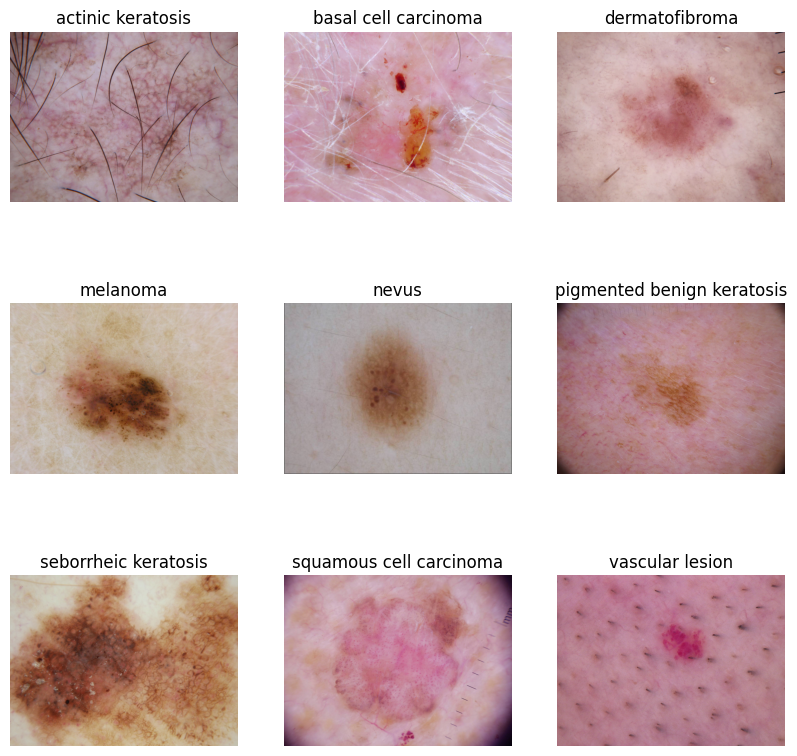

In [11]:
plt.figure(figsize=(10,10))
# to display one image per class
for i in range(len(class_names)):
  plt.subplot(math.ceil(len(class_names)/3),3,i+1)
  class_image = plt.imread(str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[2]))
  plt.title(class_names[i])
  plt.imshow(class_image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
# to control degree of parallelism
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **IV. Model Building & training on provided data**
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Initialization of Sequential CNN framework
model = Sequential()
# Rescales the pixel values of the input images to the range [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Convolutional Layers
# padding 'same' is selected to ensure no information loss(spatial dimensions of output equals to input)
# RELU activation function is used except for output layer(Softmax)
# First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# To flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())
# Dense Layer
model.add(layers.Dense(128,activation='relu'))
# Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))
# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy is choosen as loss function.

# To reduce learning rate if no improvement seen in validation accuracy for consecutive 5 epochs

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])


In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [16]:
# We are using 20 epochs to train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 260s 937ms/step - loss: 2.2192 - accuracy: 0.2204 - val_loss: 1.9627 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8996 - accuracy: 0.3013 - val_loss: 1.6455 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6408 - accuracy: 0.4275 - val_loss: 1.5878 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4871 - accuracy: 0.4738 - val_loss: 1.4224 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.4115 - accuracy: 0.5073 - val_loss: 1.5299 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3031 - accuracy: 0.5346 - val_loss: 1.3566 - val_accuracy: 0.5302 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 

### Visualizing training results

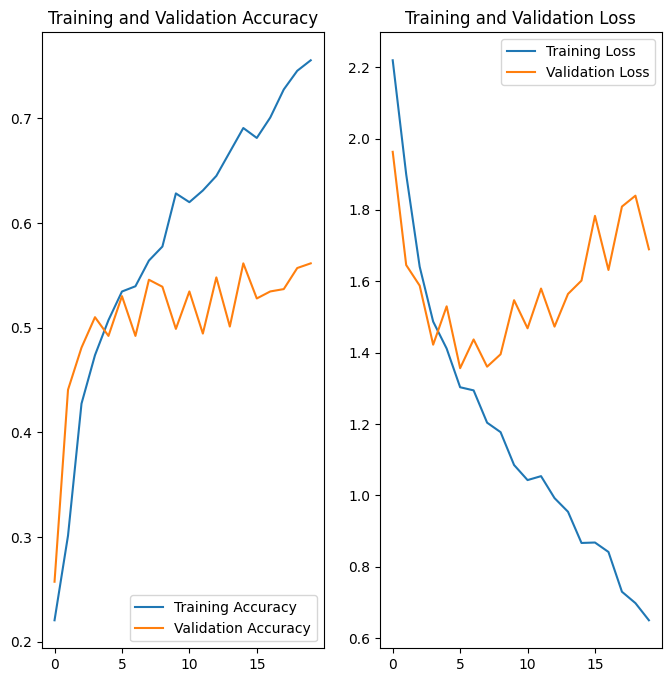

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Findings**

1. The difference between Traing accuracy and validation accuracy kept on increasing through epochs which suggests that current model is overfitting
2. Training loss is very low, but validation loss is fluctuating.

Thus we can collect that the model is not good.

### **V. Model Building & training on Augmented data**

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
  ]
)

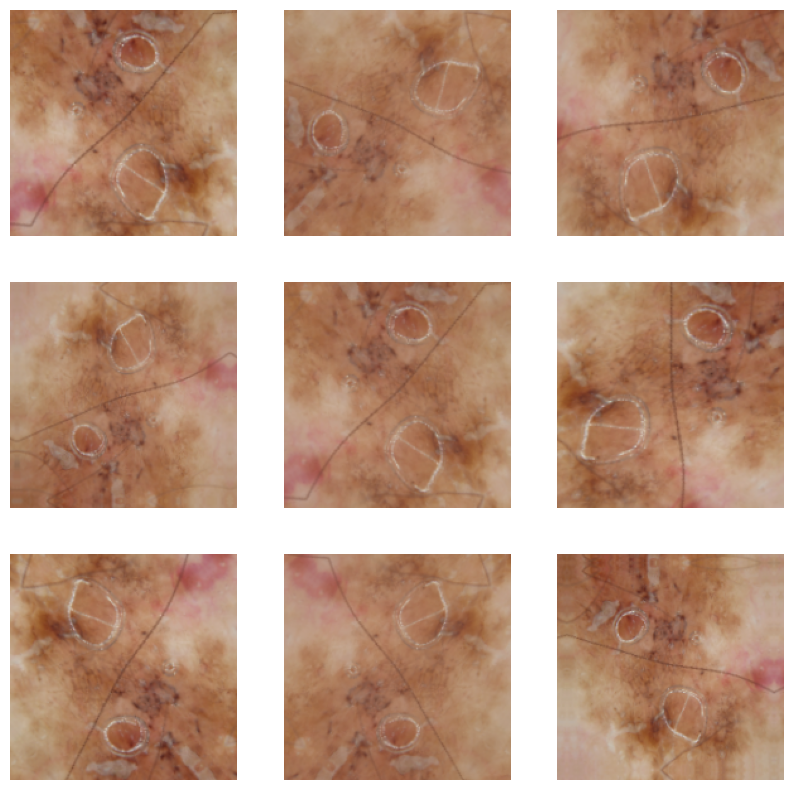

In [19]:
# Visualising augmented images for one instance of training image.
plt.figure(figsize=(10, 10))
for image, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Initialization of Sequential CNN framework
model = Sequential()
# Rescales the pixel values of the input images to the range [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# Data augmentation
model.add(data_augmentation)
# Convolutional Layers
# padding 'same' is selected to ensure no information loss(spatial dimensions of output equals to input)
# RELU activation function is used except for output layer(Softmax)
# First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# To flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())
# Dense Layer
model.add(layers.Dense(128,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Compiling the model

In [21]:
# Compiling the model with learning rate control
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

### Training the model

In [22]:
## Training  Augmented model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 6s 61ms/step - loss: 2.1284 - accuracy: 0.2042 - val_loss: 1.9763 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 1.8693 - accuracy: 0.3259 - val_loss: 1.6583 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6604 - accuracy: 0.4129 - val_loss: 1.5985 - val_accuracy: 0.4385 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5209 - accuracy: 0.4671 - val_loss: 1.4498 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5081 - accuracy: 0.4682 - val_loss: 1.5640 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.5277 - accuracy: 0.4581 - val_loss: 1.4804 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4

### Visualizing the results

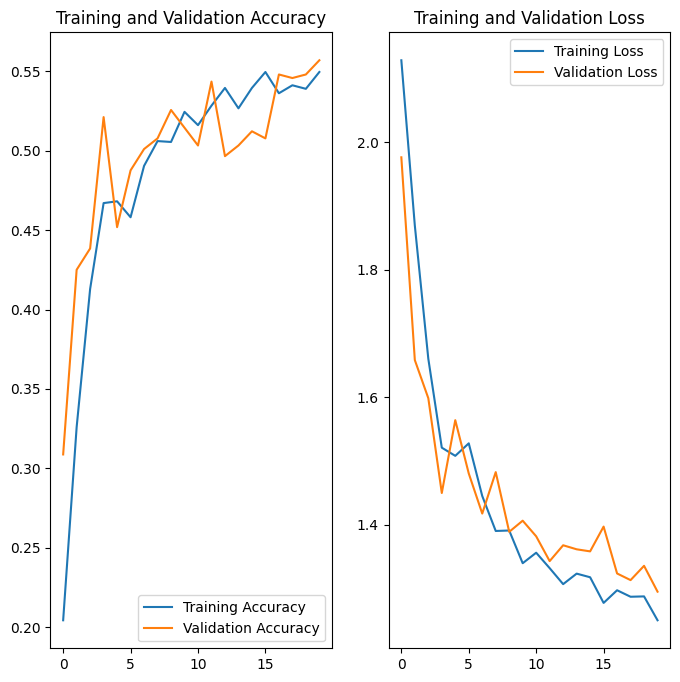

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**

1. The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low(underfit). The model requires more epochs to train with class imbalance handled.

### **VI. Model Building & training on data after handling class imbalance**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
# images count in each classes

class_imbalance = pd.DataFrame()
for i in range(len(class_names)):
    cls_name = class_names[i]
    number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
    class_imbalance = pd.concat([class_imbalance, pd.DataFrame({'class': [cls_name], 'number': [number]})])

class_imbalance.reset_index(drop=True, inplace=True)
class_imbalance


,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<ipython-input-25-12412dc28a00>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='number', y='class', data=class_imbalance_sorted, palette='viridis')


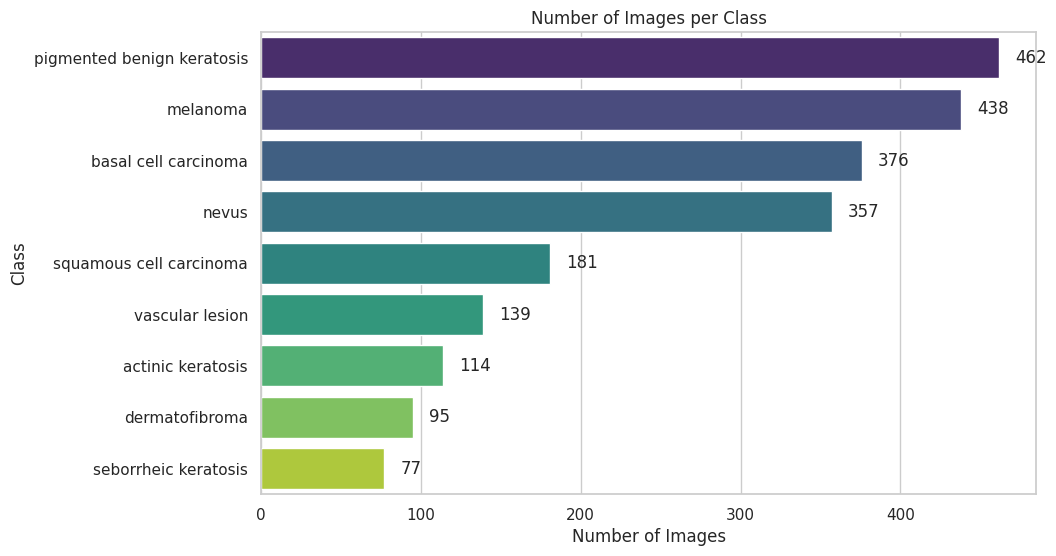

In [25]:
class_imbalance_sorted = class_imbalance.sort_values(by='number', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x='number', y='class', data=class_imbalance_sorted, palette='viridis')

# Annotate each bar with its count
for i in range(len(class_imbalance_sorted)):
    count = class_imbalance_sorted.iloc[i]['number']
    plt.text(count + 10, i, str(count), va='center', fontsize=12)

plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Number of Images per Class')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**seborrheic keratosis (77)**
#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis (462)**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5D42403E50>: 100%|██████████| 500/500 [00:21<00:00, 22.82 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E5D42413D60>: 100%|██████████| 500/500 [00:22<00:00, 21.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5D426AB4F0>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7E5DB01E2A10>: 100%|██████████| 500/500 [01:24<00:00,  5.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5DB7F6B370>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5D427CA500>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5D426DF1F0>: 100%|██████████| 500/500 [00:39<00:00, 12.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5D42543670>: 100%|██████████| 500/500 [00:20<00:00, 24.13 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5D426DF670>: 100%|██████████| 500/500 [00:19<00:00, 25.61 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
# newly augmented images
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [33]:
# To get second level directories names which contain output directory with augmented class balanced images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [34]:
# To map output files to subdirectories and store them as dict
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
path_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
path_df.head()

,Path,Label
0,/content/gdrive/My Drive/images_melanoma/Skin ...,squamous cell carcinoma
1,/content/gdrive/My Drive/images_melanoma/Skin ...,squamous cell carcinoma
2,/content/gdrive/My Drive/images_melanoma/Skin ...,squamous cell carcinoma
3,/content/gdrive/My Drive/images_melanoma/Skin ...,squamous cell carcinoma
4,/content/gdrive/My Drive/images_melanoma/Skin ...,squamous cell carcinoma


In [36]:
path_df['Label'].value_counts()

Label
squamous cell carcinoma       500
actinic keratosis             500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
pigmented benign keratosis    500
dermatofibroma                500
melanoma                      500
basal cell carcinoma          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
len(glob(os.path.join(data_dir_train, 'seborrheic keratosis','output', '*.jpg')))

500

#### **Todo:** Create a training dataset

In [39]:
data_dir_train="/content/gdrive/My Drive/images_melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here

## You can use Dropout layer if there is an evidence of overfitting in your findings
# Initialization of Sequential CNN framework
model = Sequential()
# Rescales the pixel values of the input images to the range [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Convolutional Layers
# padding 'same' is selected to ensure no information loss(spatial dimensions of output equals to input)
# RELU activation function is used except for output layer(Softmax)
# First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Fourth Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(5,5),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# To flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())
# Dense and Dropout Layers
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))



In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
# Compiling the model with learning rate control
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

#### **Todo:**  Train your model

In [50]:
epochs = 30
## Training the model for 30 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
169/169 [==============================] - 46s 243ms/step - loss: 2.1592 - accuracy: 0.1589 - val_loss: 1.9813 - val_accuracy: 0.2739 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 44s 252ms/step - loss: 1.8699 - accuracy: 0.2800 - val_loss: 1.6537 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 42s 242ms/step - loss: 1.6907 - accuracy: 0.3427 - val_loss: 1.6721 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 43s 245ms/step - loss: 1.5341 - accuracy: 0.3978 - val_loss: 1.3858 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 42s 240ms/step - loss: 1.4203 - accuracy: 0.4432 - val_loss: 1.2567 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 42s 244ms/step - loss: 1.3651 - accuracy: 0.4750 - val_loss: 1.3883 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

#### **Todo:**  Visualize the model results

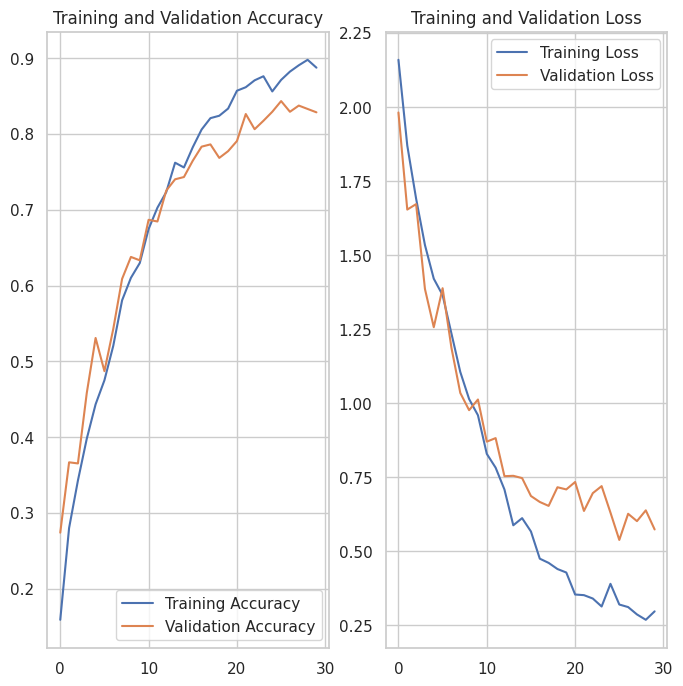

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

After Training the model on augmented data(more number of images per each class) and for more epochs, helped model learn the parameters better. Now, training accuracy and validation accuracy are above 85% which is a good fit and we can still improve this by making more complex model with regularization


1/1 [==============================] - 0s 29ms/step
Actual Class: dermatofibroma
Predictive Class: dermatofibroma


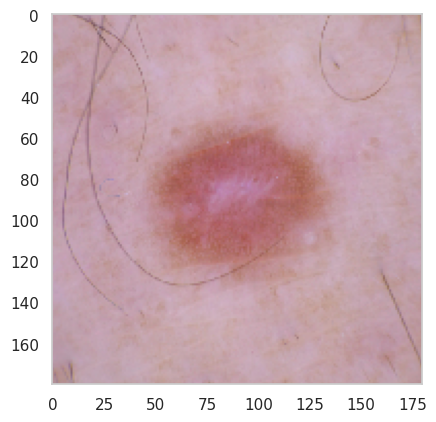

In [53]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[2]}" + '\n' + "Predictive Class: " + pred_class)